# Compare mutants to each other
Combine replicate data and compare various mutants to each other. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import pandas as pd
pd.set_option('display.max_columns', 150)
import glob
import os
from sklearn.neighbors import KernelDensity
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from scipy import stats
from scipy.spatial import distance
from sklearn.metrics import log_loss as LL
from scipy.optimize import curve_fit

def theo_pdf_fit(V,V_0,alpha):
    grate = 0.005
    return (np.maximum(0,alpha*(V - V_0))/(grate*V))*(np.power(V/V_0,alpha*V_0/grate))*np.exp(-np.maximum(0,alpha*(V - V_0))/grate)

def theo_pdf_plot(V,V_0,alpha,grate):
    return (np.maximum(0,alpha*(V - V_0))/(grate*V))*(np.power(V/V_0,alpha*V_0/grate))*np.exp(-np.maximum(0,alpha*(V - V_0))/grate)


def deviance(X, y, model):
    return 2*LL(y, model.predict_proba(X), normalize=False)

def set_axes(ax):
    ax.spines["bottom"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["bottom"].set_zorder(10)
    ax.spines["top"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["top"].set_zorder(10)
    ax.spines["left"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["left"].set_zorder(10)
    ax.spines["right"].set_linewidth(ax_fontdict['spines_w'])
    ax.spines["right"].set_zorder(10)
    ax.tick_params(axis='both',
                   which = 'major',
                   labelsize=ax_fontdict['size'],
                   colors=ax_fontdict['color'],
                   pad = ax_fontdict['pad'],
                   length = ax_fontdict['tick_l'],
                   width = ax_fontdict['tick_w'],)
    ax.tick_params(axis='both',
                   which = 'minor',
                   labelsize=0,
                   colors=ax_fontdict['color'],
                   pad = ax_fontdict['pad'],
                   length = ax_fontdict['tick_l']/2,
                   width = ax_fontdict['tick_w']/2,)
    return ax

ax_fontdict = {'family':'sans',
               'color':'black',
               'weight':'normal',
               'size':25,
               'pad':8,
               'spines_w':2,
               'tick_l':8,
               'tick_w':2,
              }

new_color_d1 = '#005493'
new_color_d2 = '#95B1E7'
new_color_m1 = '#FF9300'
new_color_m2 = '#FFD479'
new_color_all = [216/255,27/255,88/255]#;%[77/255 139/255 96/255];%'#4D8B60';
new_color_START = [216/255,27/255,88/255]#;%'#008F00';
new_color_div_d = [0/255, 77/255, 46/255]#;%[181/255 23/255 0];%'#B51700';
new_color_div_m = [117/255, 225/255, 225/255]#;%[152/255 59/255 201/255];%'#983BC9';
new_color_psg1_d = '#FFFFFF'
new_color_psg1_m = '#929292'

cmap = mpl.colormaps['Set2']
n = 8
values = np.linspace(0, 1, n)
colors = cmap(values)

# Combine all experiments and compare mutants with each other

In [11]:
mutants = ['cln3','cln3whi5','WT']
mutant_names = ['cln3','cln3whi5','WT Glucose']

window = 3
analysis_dict = {}

first_gen_vol_birth = []
first_gen_g1_growth = []
first_gen_g1_growth_smooth_vol = []
first_gen_vol_g1_s = []
fg_vg1s_relgen = {}

gr_fit = []

subhist = {}
md_asymmetry = {}

daughter_g1_length = []
mother_g1_length = []
mother_vol_birth = []
mother_vol_g1_s = []

end_vol = []
end_gen = []
end_cc = []

bs=10
bins = np.arange(0,351,bs)

jsd_end = [0.32987]
jsd_g1s = [0.08720]
cv_end = [0.40741]
cv_g1s = [0.23914]

for imut, mutant in enumerate(mutants):
    print("Mutant ",mutant)
    first_gen_vol_birth.append([])
    first_gen_g1_growth.append([])
    first_gen_g1_growth_smooth_vol.append([])
    first_gen_vol_g1_s.append([])
    ####
    fg_vg1s_relgen[mutant] = {}
    ####

    daughter_g1_length.append([])
    mother_g1_length.append([])
    mother_vol_birth.append([])
    mother_vol_g1_s.append([])
    #####
    subhist[mutant] = [[],[]]
    #####
    end_vol.append([])
    end_gen.append([])
    end_cc.append([])
    
    analysis_dict[mutant] = {}
    
    if mutant == 'cln3whi5':
        experiments = ["230822_JX_JK93","230823_FPG_JK93"]
    elif mutant == 'cln3':
        experiments = ["230811_FPG_JK94","230830_FPG_JK94"]
    elif mutant == 'WT':
        experiments = ["210120_Yagya_WT","210121_Yagya_WT"]
    else:
        experiments = []

    for iexp,experiment in enumerate(experiments):


        if experiment == "230811_FPG_JK94":
            max_pos = 9
            framerate = 6
            min_pos = 1
            bw=7
        elif experiment == "230822_JX_JK93":
            max_pos = 8
            min_pos = 1
            framerate = 6 
            bw=7
        elif experiment == "230823_FPG_JK93":
            framerate = 6 
            min_pos = 1
            max_pos = 11
            bw=7
        elif experiment == "230830_FPG_JK94":
            framerate = 6 
            min_pos = 1
            max_pos = 7
            bw=7
        elif experiment == "210120_Yagya_WT":
            framerate = 3
            min_pos = 1
            max_pos = 6
            bw=6
        elif experiment == "210121_Yagya_WT":
            framerate = 3
            min_pos = 1
            max_pos = 5
            bw=6
        else:
            max_pos = 1
            min_pos = 1
        analysis_dict[mutant][experiment] = {}
        fg_vg1s_relgen[mutant][experiment] = {}
        print('Experiment: '+experiment+'\n')

        for pos in range(min_pos,max_pos+1):
            print('Position: '+str(pos))

            if experiment == "230823_FPG_JK93":
                if pos < 10:
                    load_path = glob.glob(os.path.join("Movies",experiment,"Position_"+str(pos),experiment+"_pos*_g_s0"+str(pos)+"_acdc_output.csv"))[0]
                else:
                    load_path = glob.glob(os.path.join("Movies",experiment,"Position_"+str(pos),experiment+"_pos*_g_s"+str(pos)+"_acdc_output.csv"))[0]
            elif experiment == "210120_Yagya_WT":
                load_path = glob.glob(os.path.join("Movies",experiment,"Position_"+str(pos),"SCD_20"+experiment[0:6]+"_6strains_s0*_phase_contr_acdc_output.csv"))[0]
            elif experiment == "210121_Yagya_WT":
                load_path = glob.glob(os.path.join("Movies",experiment,"Position_"+str(pos),"SCD_20"+experiment[0:6]+"_6strains_s0*_acdc_output.csv"))[0]
            else:
                load_path = glob.glob(os.path.join("Movies",experiment,"Position_"+str(pos),experiment+"_pos*_g_s"+str(pos)+"_acdc_output.csv"))[0]

            master_df = pd.read_csv(load_path)
            if mutant in ['WT','ccr4','ccr4whi5']:
                relevant_columns = ["frame_i","time_seconds","Cell_ID","cell_area_um2","cell_cycle_stage","cell_vol_fl",
                               "division_frame_i","emerg_frame_i","generation_num","is_cell_dead","is_cell_excluded",
                               "is_history_known","relationship","relative_ID"]
            else:
                relevant_columns = ["frame_i","time_minutes","Cell_ID","cell_area_um2","cell_cycle_stage","cell_vol_fl",
                               "division_frame_i","emerg_frame_i","generation_num","is_cell_dead","is_cell_excluded",
                               "is_history_known","relationship","relative_ID"]
            filtered_df = master_df.loc[:, relevant_columns]

            IDS = np.unique(np.array(filtered_df["Cell_ID"]))
            analysis_dict[mutant][experiment]['Position_'+str(pos)] = {} #This is the nested analysis dictionary

            for i,ID in enumerate(IDS):
                # Loop over each unique cell ID
                analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(ID)] = {} # Add an item in the dict. for each ID
                gen_num = np.unique(filtered_df[filtered_df.Cell_ID == ID]["generation_num"]) # Get each generation for each ID

                for gen in gen_num:
                    # Loop over each unique generation number. If == 0, it's a bud. 

                    temp_df = filtered_df[(filtered_df.Cell_ID == ID) & (filtered_df.generation_num == gen)]
                    if np.array(temp_df["is_cell_excluded"])[0] == 1 or np.array(temp_df["is_cell_dead"])[0] == 1 or np.array(temp_df["is_history_known"])[0] == 0:
                        continue
                    # For each ID and Generation, we get the time, volume and cell cycle stage series.
                    vol = np.array(temp_df["cell_vol_fl"])
                    if mutant in ['WT','ccr4','ccr4whi5']:
                        time = np.array(temp_df["time_seconds"])*60
                    else:
                        time = np.array(temp_df["time_minutes"])
                    cc = np.array(temp_df["cell_cycle_stage"])

                    g1 = np.where(cc == 'G1')[0]
                    # Is the cell in G1? Record the initial size V(t_i) and the subsequent growth in 
                    # the time frame \Delta V = V(t_i+1) - V(t_i) to estimate the G1 growth rate
                    if len(g1) > 2*np.floor(window/2) and gen == 1:
                        smooth_vol_g1 = np.convolve(vol[g1], np.ones(window)/window, mode='valid')
                        first_gen_g1_growth_smooth_vol[imut].extend(smooth_vol_g1[:-1])
                        first_gen_g1_growth[imut].extend(np.diff(smooth_vol_g1))


                    rel_ID_at_birth = np.array(temp_df["relative_ID"])[0]
                    rel_ID =  np.array(temp_df["relative_ID"])
                    # Add these to the dict. 
                    analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)] = {'Time':time,'Volume':vol,'Cell_cycle':cc,'Rel_ID_at_birth':rel_ID_at_birth,'Rel_ID':rel_ID}

                    # Now we will extract specific values corresponding to birth, G1/S and division for each cell and each gen.
                    vol_birth = vol[0]
                    time_birth = time[0]
                    analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_birth'] = vol_birth
                    analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Time_birth'] = time_birth

                    flag = 0
                    flag2 = 0
                    for j, jcc in enumerate(cc):
                        if np.array(temp_df["is_cell_excluded"])[j] == 1 or np.array(temp_df["is_cell_dead"])[j] == 1 or np.array(temp_df["is_history_known"])[j] == 0:
                            continue

                        g1_s = np.where(cc == 'S')[0]

                        # Has the cell undergone G1/S transition 
                        if len(g1_s) != 0 and gen != 0:
                            true_g1_s = g1_s[0]
                            vol_g1_s = vol[true_g1_s]
                            time_g1_s = time[true_g1_s] #Time since beginning of the generation
                            g1_length = time_g1_s - time_birth

                            analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_G1_S'] = vol_g1_s
                            analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Time_G1_S'] = time_g1_s
                            analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['G1_length'] = g1_length

                            if gen == 1 and flag == 0:
                                first_gen_vol_g1_s[imut].append(vol_g1_s)
                                daughter_g1_length[imut].append(g1_length)
                                first_gen_vol_birth[imut].append(vol_birth)
                                flag = 1
                            elif gen > 1 and flag2 == 0:
                                mother_g1_length[imut].append(g1_length)
                                mother_vol_birth[imut].append(vol_birth)
                                mother_vol_g1_s[imut].append(vol_g1_s)
                                flag2 = 1

                        # Has the cell divided before the last frame? 
                        if gen != gen_num[-1] and gen != 0:
                            time_div = time[-1]
                            vol_div = vol[-1]
                            sg2m_length = time_div - time_g1_s

                            analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_division'] = vol_div
                            analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Time_division'] = time_div
                            analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['SG2M_length'] = sg2m_length

                        # Last frame steady-state volumes
                        if gen == gen_num[-1] and j == len(cc)-1:

                            vol_last_frame = vol[-1]
                            analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Volume_last'] = vol_last_frame  
                            analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(ID)]['Generation_'+str(gen)]['Cell_cycle_last'] = jcc

                            #Add bud volume to mother cell body
                            if gen == 0:
                                relative_ID = np.array(filtered_df[(filtered_df.Cell_ID == ID) & (filtered_df.generation_num == gen)]["relative_ID"])[0]
                                relative_gen_num = np.unique(filtered_df[filtered_df.Cell_ID == relative_ID]["generation_num"])
                                if 'Generation_'+str(relative_gen_num[-1]) in analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(relative_ID)].keys():
                                    analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(relative_ID)]['Generation_'+str(relative_gen_num[-1])]['Volume_last'] += vol_last_frame
                                else:
                                    continue

            for i,ID in enumerate(analysis_dict[mutant][experiment]['Position_'+str(pos)].keys()):
                for j,gen in enumerate(analysis_dict[mutant][experiment]['Position_'+str(pos)][ID].keys()):
                    if 'Volume_last' in analysis_dict[mutant][experiment]['Position_'+str(pos)][ID][gen] and gen[-1] != "0":
                        #if analysis_dict[ID][gen]['Volume_last'] < 20:
                            #print(ID,gen,analysis_dict[ID][gen]['Volume_last'])
                        end_vol[imut].append(analysis_dict[mutant][experiment]['Position_'+str(pos)][ID][gen]['Volume_last'])
                        end_gen[imut].append(int(gen[-1]))
                        end_cc[imut].append(analysis_dict[mutant][experiment]['Position_'+str(pos)][ID][gen]['Cell_cycle_last'])

            for i,ID in enumerate(analysis_dict[mutant][experiment]['Position_'+str(pos)].keys()):
                for j,gen in enumerate(analysis_dict[mutant][experiment]['Position_'+str(pos)][ID].keys()):
                    #if ID[-3] == '_':
                        #temp_df = filtered_df[(filtered_df.Cell_ID == int(ID[-2:])) & (filtered_df.generation_num == int(gen[-1]))]
                    #elif ID[-2] == '_':  
                        #temp_df = filtered_df[(filtered_df.Cell_ID == int(ID[-1])) & (filtered_df.generation_num == int(gen[-1]))]

                    #if np.any(np.array(temp_df["is_cell_excluded"]) == 1) or np.any(np.array(temp_df["is_cell_dead"]) == 1) or np.any(np.array(temp_df["is_history_known"]) == 0):
                        #continue
                    if gen == "Generation_1" and 'Time_G1_S' in analysis_dict[mutant][experiment]['Position_'+str(pos)][ID][gen].keys():
                        temp_time_birth = analysis_dict[mutant][experiment]['Position_'+str(pos)][ID][gen]['Time_birth']
                        rel_ID = analysis_dict[mutant][experiment]['Position_'+str(pos)][ID][gen]['Rel_ID_at_birth']
                        # Loop through the generations of the relative ID
                        for rel_gen in analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(rel_ID)].keys():
                            # Identify the corresponding generation
                            # Not every 1st gen cells will have a corresponding relative whose history is known, so 
                            # sample size of first_gen_vol_g1_s_rel is smaller than first_gen_vol_g1_s
                            temp_rel_df = filtered_df[(filtered_df.Cell_ID == int(rel_ID)) & (filtered_df.generation_num == int(rel_gen[-1])-1)]
                            if np.any(np.array(temp_rel_df["is_cell_excluded"]) == 1) or np.any(np.array(temp_rel_df["is_cell_dead"]) == 1) or np.any(np.array(temp_rel_df["is_history_known"]) == 0):
                                continue
                            elif temp_time_birth == analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(rel_ID)][rel_gen]["Time_birth"]:
                                #first_gen_vol_g1_s_rel_gen.append(int(rel_gen[-1])-1)
                                # Record previous generation
                                if 'Generation_'+str(int(rel_gen[-1])-1) not in fg_vg1s_relgen[mutant][experiment].keys():
                                    fg_vg1s_relgen[mutant][experiment]['Generation_'+str(int(rel_gen[-1])-1)] = {}
                                    fg_vg1s_relgen[mutant][experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Volume_birth'] = []
                                    fg_vg1s_relgen[mutant][experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Volume_G1_S'] = []
                                    fg_vg1s_relgen[mutant][experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Mother_volume_G1_S'] = []
                                    fg_vg1s_relgen[mutant][experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Mother_volume_division'] = []
                                fg_vg1s_relgen[mutant][experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Volume_birth'].append(analysis_dict[mutant][experiment]['Position_'+str(pos)][ID][gen]['Volume_birth'])
                                fg_vg1s_relgen[mutant][experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Volume_G1_S'].append(analysis_dict[mutant][experiment]['Position_'+str(pos)][ID][gen]['Volume_G1_S'])
                                fg_vg1s_relgen[mutant][experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Mother_volume_G1_S'].append(analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(rel_ID)]['Generation_'+str(int(rel_gen[-1])-1)]['Volume_G1_S'])
                                fg_vg1s_relgen[mutant][experiment]['Generation_'+str(int(rel_gen[-1])-1)]['Mother_volume_division'].append(analysis_dict[mutant][experiment]['Position_'+str(pos)]['Cell_'+str(rel_ID)]['Generation_'+str(int(rel_gen[-1])-1)]['Volume_division'])

md_asymmetry = {}                           
for imut, mutant in enumerate(mutants):
    md_asymmetry[mutant] = [[],[]]
    if mutant == 'cln3whi5':
        experiments = ["230822_JX_JK93","230823_FPG_JK93"]
    elif mutant == 'cln3':
        experiments = ["230811_FPG_JK94","230830_FPG_JK94"]
    elif mutant == 'WT':
        experiments = ["210120_Yagya_WT","210121_Yagya_WT"]
    elif mutant == 'ccr4':
        experiments = ["210121_Yagya_ccr4","231212_Yagya_ccr4"]
    elif mutant == 'ccr4whi5':
        experiments = ["210120_Yagya_ccr4whi5","210121_Yagya_ccr4whi5"]
    else:
        experiments = []
    for iexp,experiment in enumerate(experiments):
        for i,rel_gen in enumerate(fg_vg1s_relgen[mutant][experiment].keys()):
            
            md_asymmetry[mutant][0].extend(fg_vg1s_relgen[mutant][experiment][rel_gen]['Mother_volume_division'])
            md_asymmetry[mutant][1].extend(fg_vg1s_relgen[mutant][experiment][rel_gen]['Volume_birth'])
            #print(len(md_asymmetry[mutant][0]),len(md_asymmetry[mutant][1]))
            if i == 0:
                subhist[mutant][0].extend(fg_vg1s_relgen[mutant][experiment][rel_gen]['Volume_G1_S'])
            else:
                subhist[mutant][1].extend(fg_vg1s_relgen[mutant][experiment][rel_gen]['Volume_G1_S'])
    
    p_g1s_fromdaughters, edges = np.histogram(subhist[mutant][0],bins=bins,density=1)
    p_g1s_frommothers, edges = np.histogram(subhist[mutant][1],bins=bins,density=1)
    
    jsd_g1s.append(distance.jensenshannon(p_g1s_fromdaughters,p_g1s_frommothers))
    
    daughter_end_vol = np.array(end_vol[imut])[np.where(np.array(end_gen[imut]) == 1)]
    mother_end_vol = np.array(end_vol[imut])[np.where(np.array(end_gen[imut]) != 1)]
    
    p_end_daughters,edges = np.histogram(daughter_end_vol,bins=bins,density=1)
    p_end_mothers,edges = np.histogram(mother_end_vol,bins=bins,density=1)
    jsd_end.append(distance.jensenshannon(p_end_daughters,p_end_mothers))
    
    cv_end.append(np.std(end_vol[imut])/np.mean(end_vol[imut]))
    cv_g1s.append(np.std(first_gen_vol_g1_s[imut])/np.mean(first_gen_vol_g1_s[imut]))    
    

Mutant  cln3
Experiment: 230811_FPG_JK94

Position: 1
Position: 2
Position: 3
Position: 4
Position: 5
Position: 6
Position: 7
Position: 8
Position: 9
Experiment: 230830_FPG_JK94

Position: 1
Position: 2
Position: 3
Position: 4
Position: 5
Position: 6
Position: 7
Mutant  cln3whi5
Experiment: 230822_JX_JK93

Position: 1
Position: 2
Position: 3
Position: 4
Position: 5
Position: 6
Position: 7
Position: 8
Experiment: 230823_FPG_JK93

Position: 1
Position: 2
Position: 3
Position: 4
Position: 5
Position: 6
Position: 7
Position: 8
Position: 9
Position: 10
Position: 11
Mutant  WT
Experiment: 210120_Yagya_WT

Position: 1
Position: 2
Position: 3
Position: 4
Position: 5
Position: 6
Experiment: 210121_Yagya_WT

Position: 1
Position: 2
Position: 3
Position: 4
Position: 5


# Plot the level of asymmetry between subpopulations

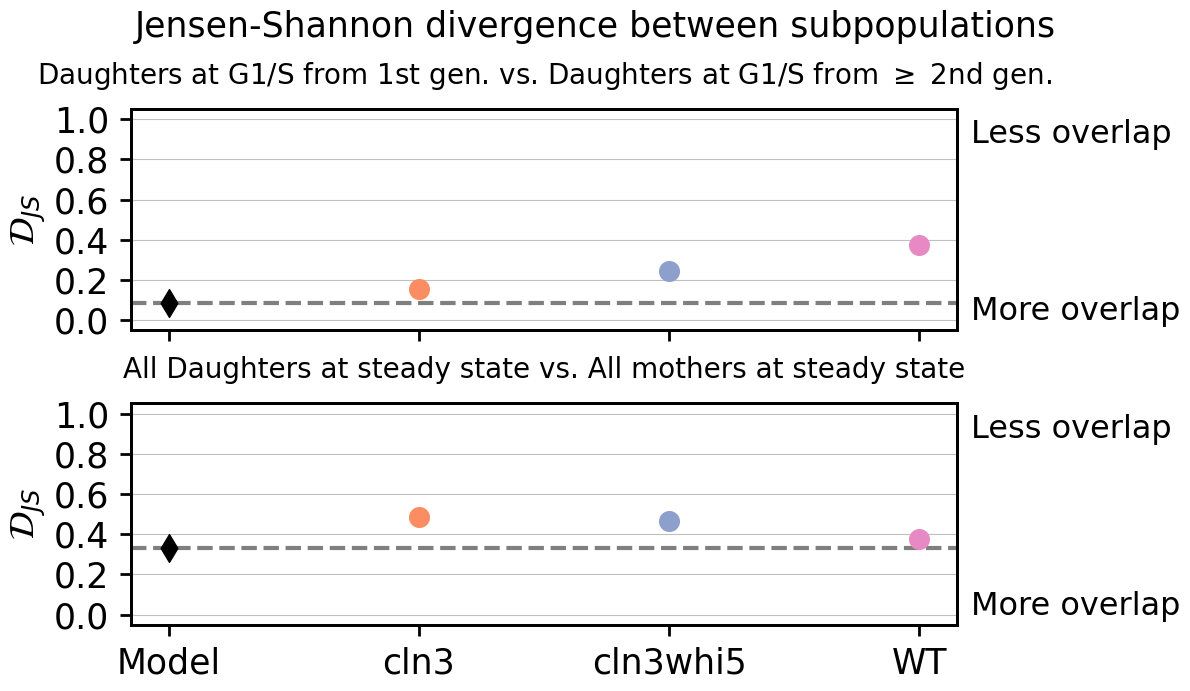

In [14]:
jsd_end_baseline = 0.322
jsd_g1s_baseline = 0.0693

rel = 0 # If rel == 1, plot the relative 
if rel == 1:
    jsd_end_plot = np.divide(jsd_end,jsd_end_baseline)
    jsd_g1s_plot = np.divide(jsd_g1s,jsd_g1s_baseline)
else:
    jsd_end_plot = np.divide(jsd_end,1)
    jsd_g1s_plot = np.divide(jsd_g1s,1)
f, ax = plt.subplots(2,1,figsize=(12,7),tight_layout=1)
ax0 = set_axes(ax[0])
ax1 = set_axes(ax[1])

ax00 = ax0.twinx()
ax11 = ax1.twinx()
ax00, ax11 = set_axes(ax00),set_axes(ax11)
ax00.set_yticks([0.1,0.9])
ax00.set_yticklabels(['More overlap','Less overlap'],fontsize=ax_fontdict['size']-2)
ax11.set_yticks([0.1,0.9])
ax11.set_yticklabels(['More overlap','Less overlap'],fontsize=ax_fontdict['size']-2)
ax00.tick_params(length=0,pad=10)
ax11.tick_params(length=0,pad=10)
#ax0.scatter(0,jsd_g1s[0]/jsd_g1s_baseline,s=50,color='k',marker='d')
#ax1.scatter(0,jsd_end[0]/jsd_end_baseline,s=50,color='k',marker='d')
for imut in range(len(mutants)+1):
    if imut == 0:
        ax0.axhline(jsd_g1s_plot[imut],lw=3,ls='--',color='k',alpha=0.5,zorder=1)
        ax1.axhline(jsd_end_plot[imut],lw=3,ls='--',color='k',alpha=0.5,zorder=1)
        ax0.scatter(imut,jsd_g1s_plot[imut],s=200,color='k',marker='d',zorder=2)
        ax1.scatter(imut,jsd_end_plot[imut],s=200,color='k',marker='d',zorder=2)
    else:
        ax0.scatter(imut,jsd_g1s_plot[imut],s=200,color=colors[imut],zorder=2)
        ax1.scatter(imut,jsd_end_plot[imut],s=200,color=colors[imut],zorder=2)

ax0.set_xticks([0,1,2,3])  
ax0.set_xticklabels(['','','',''])
ax1.set_xticks([0,1,2,3,])
ax1.set_xticklabels(['Model']+mutants,fontsize=ax_fontdict['size'])
ax0.grid(axis='y',alpha=0.8)
ax1.grid(axis='y',alpha=0.8)

if rel:
    ymax0,ymin0 = 1.2*max(jsd_g1s_plot),0.05*min(jsd_g1s_plot)
    ymax1,ymin1 = 1.2*max(jsd_end_plot),0.8*min(jsd_end_plot)
    ax0.set_ylim([ymin0,ymax0])
    ax1.set_ylim([ymin1,ymax1])
else:
    ax0.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax1.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax0.set_ylim([-0.05,1.05])
    ax1.set_ylim([-0.05,1.05])
    ax0.set_ylabel(r'$\mathcal{D}_{JS}$',fontsize=ax_fontdict['size'])
    ax1.set_ylabel(r'$\mathcal{D}_{JS}$',fontsize=ax_fontdict['size'])
ax0.set_title('Daughters at G1/S from 1st gen. vs. Daughters at G1/S from $\geq$ 2nd gen.'
              ,fontsize=ax_fontdict['size']-5,pad=ax_fontdict['pad']+10)
ax1.set_title('All Daughters at steady state vs. All mothers at steady state'
              ,fontsize=ax_fontdict['size']-5,pad=ax_fontdict['pad']+10)

if rel:
    plt.suptitle('Relative Jensen-Shannon divergence between subpopulations',fontsize=ax_fontdict['size'])
    #plt.savefig(os.path.join("Mutant_summary",'jensen_shannon_divergence_relative.png'),dpi=450)
else:
    plt.suptitle('Jensen-Shannon divergence between subpopulations',fontsize=ax_fontdict['size'])
    #plt.savefig(os.path.join("Mutant_summary",'jensen_shannon_divergence.png'),dpi=450)
plt.show()

# Compare mutant CV with WT and model

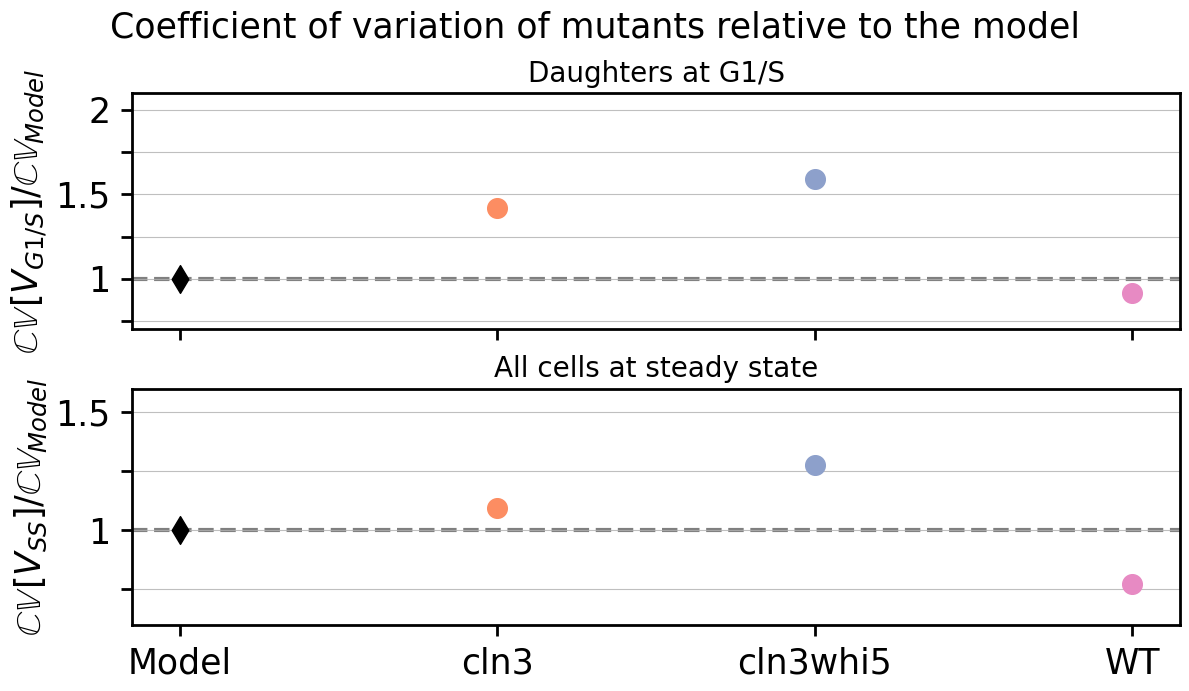

In [16]:


rel = 1 # If rel == 1, plot the relative 
if rel == 1:
    cv_end_plot = np.divide(cv_end,cv_end[0])
    cv_g1s_plot = np.divide(cv_g1s,cv_g1s[0])
else:
    cv_end_plot = np.divide(cv_end,1)
    cv_g1s_plot = np.divide(cv_g1s,1)
f, ax = plt.subplots(2,1,figsize=(12,7),tight_layout=1)
ax0 = set_axes(ax[0])
ax1 = set_axes(ax[1])


for imut in range(len(mutants)+1):
    if imut == 0:
        ax0.axhline(cv_g1s_plot[imut],lw=3,ls='--',color='k',alpha=0.5,zorder=1)
        ax1.axhline(cv_end_plot[imut],lw=3,ls='--',color='k',alpha=0.5,zorder=1)
        ax0.scatter(imut,cv_g1s_plot[imut],s=200,color='k',marker='d',zorder=2)
        ax1.scatter(imut,cv_end_plot[imut],s=200,color='k',marker='d',zorder=2)
    else:
        ax0.scatter(imut,cv_g1s_plot[imut],s=200,color=colors[imut],zorder=2)
        ax1.scatter(imut,cv_end_plot[imut],s=200,color=colors[imut],zorder=2)

ax0.set_xticks([0,1,2,3])  
ax0.set_xticklabels(['','','',''])
ax1.set_xticks([0,1,2,3])
ax1.set_xticklabels(['Model']+mutants,fontsize=ax_fontdict['size'])
ax0.grid(axis='y',alpha=0.8)
ax1.grid(axis='y',alpha=0.8)

if rel:
    #ymax0,ymin0 = 1.2*max(cv_g1s_plot),0.05*min(cv_g1s_plot)
    #ymax1,ymin1 = 1.2*max(cv_end_plot),0.8*min(cv_end_plot)
    ax0.set_yticks([0.75,1,1.25,1.5,1.75,2])
    ax1.set_yticks([0.75,1,1.25,1.5,1.75,2])
    ax0.set_yticklabels(['','1','','1.5','','2'])
    ax1.set_yticklabels(['','1','','1.5','','2'])
    ax0.set_ylim([0.7,2.1])
    ax1.set_ylim([0.6,1.6])
    ax0.set_ylabel(r'$\mathbb{CV}\,[V_{G1/S}]/\mathbb{CV}_{Model}$',fontsize=ax_fontdict['size'])
    ax1.set_ylabel(r'$\mathbb{CV}\,[V_{SS}]/\mathbb{CV}_{Model}$',fontsize=ax_fontdict['size'])
else:
    ax0.set_yticks([0.2,0.3,0.4,0.5,0.6])
    ax1.set_yticks([0.2,0.3,0.4,0.5,0.6])
    ax0.set_ylim([0.15,0.6])
    ax1.set_ylim([0.15,0.6])
    ax0.set_ylabel(r'$\mathbb{CV}\,[V_{G1/S}]$',fontsize=ax_fontdict['size'])
    ax1.set_ylabel(r'$\mathbb{CV}\,[V_{SS}]$',fontsize=ax_fontdict['size'])
ax0.set_title('Daughters at G1/S'
              ,fontsize=ax_fontdict['size']-5,pad=ax_fontdict['pad'])
ax1.set_title('All cells at steady state'
              ,fontsize=ax_fontdict['size']-5,pad=ax_fontdict['pad'])

if rel:
    plt.suptitle('Coefficient of variation of mutants relative to the model',fontsize=ax_fontdict['size'])
    #plt.savefig(os.path.join("Mutant_summary",'cv_mutants_relative.png'),dpi=450)
else:
    plt.suptitle('Coefficient of variation of mutants',fontsize=ax_fontdict['size'])
    #plt.savefig(os.path.join("Mutant_summary",'cv_mutants.png'),dpi=450)
plt.show()

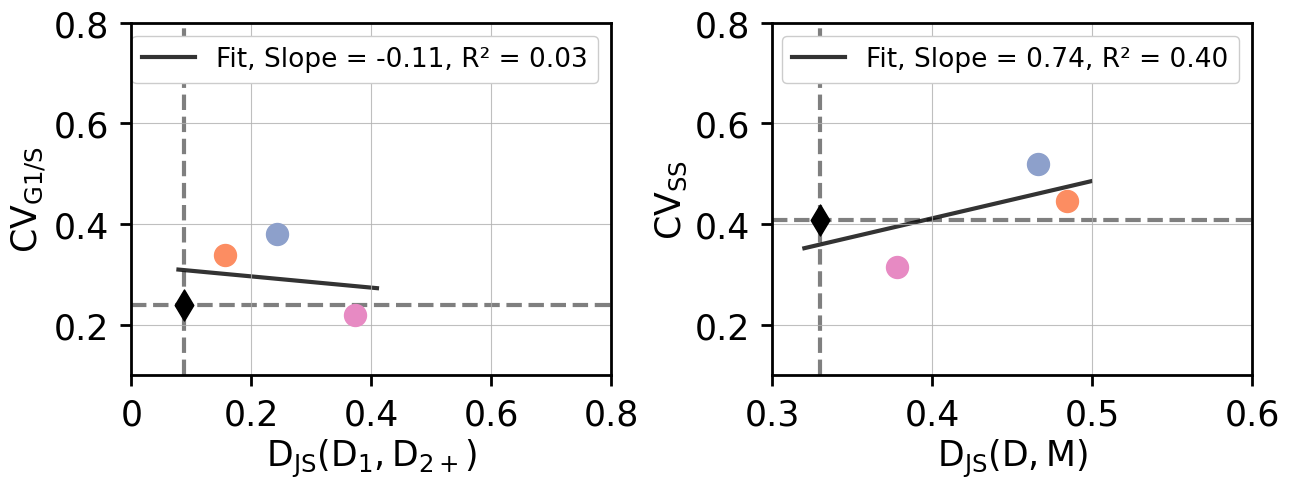

In [17]:
rel_jsd = 0 # If rel == 1, plot the relative 
rel_cv = 0

if rel_jsd:
    jsd_g1s_scatter = np.divide(jsd_g1s,jsd_g1s[0])
    jsd_end_scatter = np.divide(jsd_end,jsd_end[0])
else:
    jsd_g1s_scatter = np.divide(jsd_g1s,1)
    jsd_end_scatter = np.divide(jsd_end,1)
    
if rel_cv:
    cv_end_scatter = np.divide(cv_end,cv_end[0])
    cv_g1s_scatter = np.divide(cv_g1s,cv_g1s[0])
else:
    cv_end_scatter = np.divide(cv_end,1)
    cv_g1s_scatter = np.divide(cv_g1s,1)

X1, Y1 = np.array(jsd_g1s_scatter).reshape(-1,1),np.array(cv_g1s_scatter).reshape(-1,1)
X2, Y2 = np.array(jsd_end_scatter).reshape(-1,1),np.array(cv_end_scatter).reshape(-1,1)
regr1 = linear_model.LinearRegression()
regr2 = linear_model.LinearRegression()
# Train the model using the training sets
regr1.fit(X1,Y1)
regr2.fit(X2,Y2)
# Make predictions using the testing set
x_plot1 = np.linspace(np.amin(X1)*0.9,np.amax(X1)*1.1,50).reshape(-1,1)
x_plot2 = np.linspace(np.amin(X2)*0.97,np.amax(X2)*1.03,50).reshape(-1,1)

y_plot1 = regr1.predict(x_plot1)
y_plot2 = regr2.predict(x_plot2)

slope1 = regr1.coef_[0][0]
intercept1 = regr1.intercept_[0]
score1 = regr1.score(X1, Y1)    

slope2 = regr2.coef_[0][0]
intercept2 = regr2.intercept_[0]
score2 = regr2.score(X2, Y2)    
    
f, ax = plt.subplots(1,2,figsize=(13,5),tight_layout=1)
ax0=set_axes(ax[0])
ax1=set_axes(ax[1])

ax0.axhline(cv_g1s_scatter[0],lw=3,ls='--',color='k',alpha=0.5,zorder=1)
ax1.axhline(cv_end_scatter[0],lw=3,ls='--',color='k',alpha=0.5,zorder=1)

ax0.axvline(jsd_g1s_scatter[0],lw=3,ls='--',color='k',alpha=0.5,zorder=1)
ax1.axvline(jsd_end_scatter[0],lw=3,ls='--',color='k',alpha=0.5,zorder=1)

#ax0.scatter(jsd_g1s_scatter[0],cv_g1s_scatter[0],s=250,color='k',marker='d',zorder=2,label='Model')
#ax1.scatter(jsd_end_scatter[0],cv_end_scatter[0],s=250,color='k',marker='d',zorder=2,label='Model')
ax0.scatter(jsd_g1s_scatter[0],cv_g1s_scatter[0],s=250,color='k',marker='d',zorder=2)
ax1.scatter(jsd_end_scatter[0],cv_end_scatter[0],s=250,color='k',marker='d',zorder=2)

for imut,mutant in enumerate(mutants):
    #ax0.scatter(jsd_g1s_scatter[imut+1],cv_g1s_scatter[imut+1],s=250,color=colors[imut+1],zorder=2,label=mutant_names[imut])
    #ax1.scatter(jsd_end_scatter[imut+1],cv_end_scatter[imut+1],s=250,color=colors[imut+1],zorder=2,label=mutant_names[imut])
    ax0.scatter(jsd_g1s_scatter[imut+1],cv_g1s_scatter[imut+1],s=250,color=colors[imut+1],zorder=2)
    ax1.scatter(jsd_end_scatter[imut+1],cv_end_scatter[imut+1],s=250,color=colors[imut+1],zorder=2)
#ax0.set_title('Daughter size at G1/S',fontsize=ax_fontdict['size'],pad=10)
#ax1.set_title('All cells at steady-state',fontsize=ax_fontdict['size'],pad=10)

ax0.plot(x_plot1,y_plot1,lw=3,ls='-',c='k',alpha=0.8,zorder=1,label='Fit, Slope = %.2f, R² = %.2f'%(slope1,score1))
ax1.plot(x_plot2,y_plot2,lw=3,ls='-',c='k',alpha=0.8,zorder=1,label='Fit, Slope = %.2f, R² = %.2f'%(slope2,score2))

if rel_jsd:
    ax0.set_xlabel(r'$\mathcal{D}_{JS}(D_1,D_2) / $\mathcal{D}_{JS}(Model)$',fontsize=ax_fontdict['size'])
    ax1.set_xlabel(r'$\mathcal{D}_{JS}(D,M) / $\mathcal{D}_{JS}(Model)$',fontsize=ax_fontdict['size'])
else:
    ax0.set_xlabel(r'$\rm D_{JS}(D_1,D_{2+})$',fontsize=ax_fontdict['size'])
    ax1.set_xlabel(r'$\rm D_{JS}(D,M)$',fontsize=ax_fontdict['size'])
    ax0.set_xlim([0,0.8])
    ax1.set_xlim([0.3,0.6])
    ax0.set_xticks([0,0.2,0.4,0.6,0.8])
    ax0.set_xticklabels([0,0.2,0.4,0.6,0.8])
    #ax1.set_xticks([0,0.2,0.4,0.6,0.8])
    #ax1.set_xticklabels([0,0.2,0.4,0.6,0.8])

if rel_cv:
    ax0.set_ylabel(r'Relative CV$\rm _{G1/S}$',fontsize=ax_fontdict['size'])
    ax1.set_ylabel(r'Relative CV$\rm _{SS}$',fontsize=ax_fontdict['size'])
    ax0.set_ylim([0.8,2.2])
    ax1.set_ylim([0.8,2.2])
else:
    ax0.set_ylabel(r'CV$\rm _{G1/S}$',fontsize=ax_fontdict['size'])
    ax1.set_ylabel(r'CV$\rm _{SS}$',fontsize=ax_fontdict['size'])
    ax0.set_ylim([0.1,0.8])
    ax1.set_ylim([0.1,0.8])
    
ax0.legend(fontsize=ax_fontdict['size']-6,ncol=1,framealpha=1)
ax1.legend(fontsize=ax_fontdict['size']-6,ncol=1,framealpha=1)

ax0.grid(which='both',alpha=0.8)
ax1.grid(which='both',alpha=0.8)
#if rel_cv:
    #plt.savefig(os.path.join("Mutant_summary",'relcv_vs_jsd_scatter.png'),dpi=450)
#else:
#plt.savefig(os.path.join("Mutant_summary",'cv_vs_jsd_scatter_fit.png'),dpi=450)
plt.show()

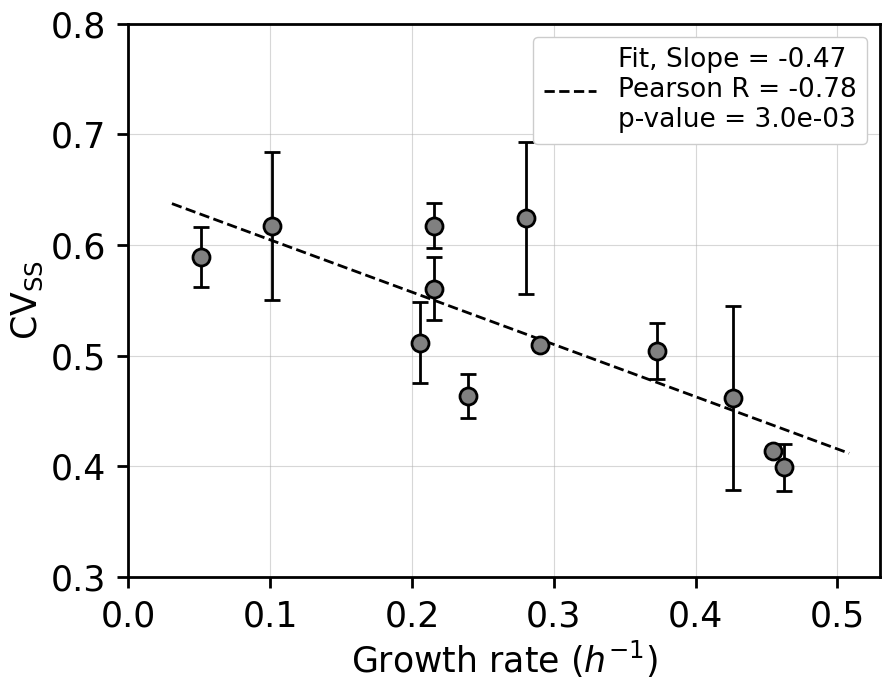

In [21]:
df = pd.read_excel('Movies/asymmetry_experiments/cv_growth_rate.xlsx')

media = np.array(df['Media'])

gr = np.array(df['growth rate'])

cv1, cv2, cv3 = np.array(df['CV1']),np.array(df['CV2']),np.array(df['CV3'])
mean1, mean2, mean3 = np.array(df['Mean1']), np.array(df['Mean2']), np.array(df['Mean3'])

cv_plot = np.nanmean([cv1,cv2,cv3],axis=0)
cv_err = np.nanstd([cv1,cv2,cv3],axis=0)

mean_plot = np.nanmean([mean1,mean2,mean3],axis=0)
mean_err = np.nanstd([mean1,mean2,mean3],axis=0)
weights = 1/mean_err

# Pearson correlation
x_data_correlation = np.tile(gr,3)
y_data_correlation = np.array([cv1,cv2,cv3]).flatten()

#Remove nan
nan_indices = np.where(np.isnan(y_data_correlation))[0]
x_data_correlation = np.delete(x_data_correlation,nan_indices)
y_data_correlation = np.delete(y_data_correlation,nan_indices)

pearson_r = stats.pearsonr(x_data_correlation,y_data_correlation)

simple_pearson_r = stats.pearsonr(gr,cv_plot)

#Fit
X, Y = np.array(gr).reshape(-1,1),np.array(cv_plot/100).reshape(-1,1)
regr = linear_model.LinearRegression(fit_intercept=True)
# Train the model using the training sets
regr.fit(X,Y,sample_weight=weights)
# Make predictions using the testing set
x_plot = np.linspace(np.amin(X)*0.6,np.amax(X)*1.1,50).reshape(-1,1)
y_plot = regr.predict(x_plot)
slope = regr.coef_[0][0]


f, ax = plt.subplots(1,1,figsize=(9,7),tight_layout=1)
ax=set_axes(ax)

ax.errorbar(gr,np.divide(cv_plot,100),yerr=np.divide(cv_err,100),color='k',lw=2,capsize=6,capthick=2,zorder=2,ls='')
ax.scatter(gr,np.divide(cv_plot,100),s=150,ec='k',lw=2,fc='gray',zorder=3)

ax.plot(x_plot,y_plot,lw=2,c='k',ls='--',label='Fit, Slope = %.2f\nPearson R = %.2f\np-value = %.1e'%(slope,simple_pearson_r.statistic,simple_pearson_r.pvalue))

#ax.set_yticks(np.arange(0,1.01,0.1))
#ax.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_ylim([0.3,0.8])
ax.set_ylabel(r'$\rm CV_{SS}$',fontsize = ax_fontdict['size'])

#ax.set_xticks(np.arange(0.5,4.6,0.5))
#ax.set_xticklabels(['0.5','1','1.5','2','2.5','3','3.5','4','4.5'])
ax.set_xlabel(r'Growth rate $(h^{-1})$',fontsize = ax_fontdict['size'])
ax.set_xlim([0,0.53])

plt.legend(fontsize=ax_fontdict['size']-6,framealpha=1)    

plt.grid(alpha=0.5,zorder=1)
#plt.savefig(os.path.join("Mutant_summary",'cv_ss_growth_rate.png'),dpi=450)

plt.show()

/home/felix/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


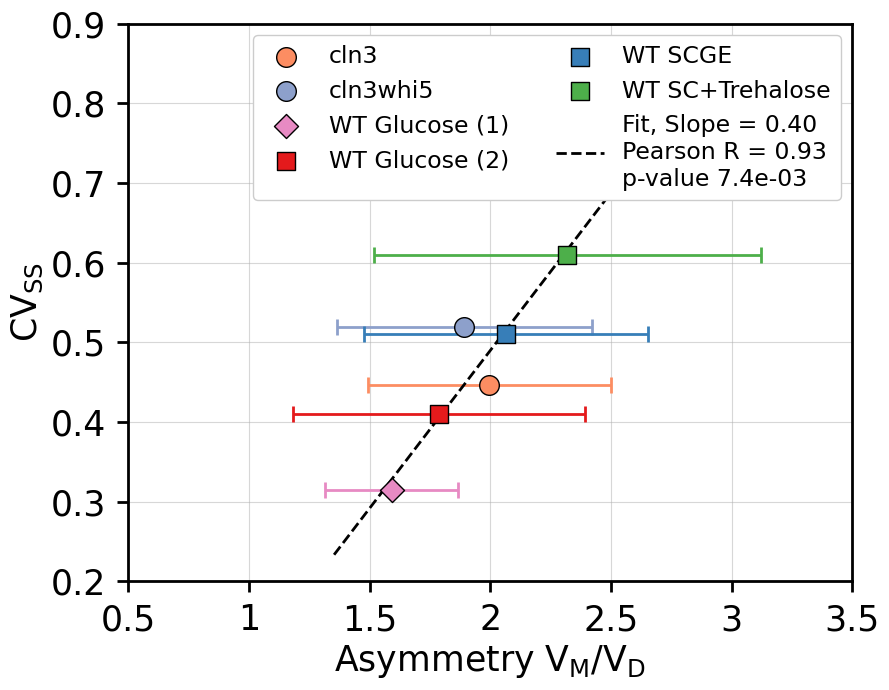

In [34]:
f, ax = plt.subplots(1,1,figsize=(9,7),tight_layout=1)
ax=set_axes(ax)

weights = []
X_data = []
Y_data = []

plot_labels = ['cln3','cln3whi5','WT Glucose (1)']
for imut, mutant in enumerate(mutants):
    if imut < 2:
        m, s = 'o', 200
    #elif imut == 2 or imut == 3:
    #    continue
    else:
        m, s = 'D', 150
    x_data = np.divide(md_asymmetry[mutant][0],md_asymmetry[mutant][1])
    x_plot = np.median(x_data)
    x_err = np.std(x_data)
    weights.append(1/x_err)
    X_data.append(x_plot)
    Y_data.append(cv_end[imut+1])
    #print(x_err)
    
    ax.errorbar(x_plot,cv_end[imut+1],xerr=x_err,color = colors[imut+1],lw=2,capsize=6,capthick=2,zorder=2)
    ax.scatter(x_plot,cv_end[imut+1],marker = m,color=colors[imut+1],ec='k',lw=1,s=s,zorder=3,label=plot_labels[imut])
    
growth_conditions = ['Glucose','SCGE','Trehalose']
approx_cv = [0.41,0.51,0.61]
df = pd.read_excel('Movies/asymmetry_experiments/asymmetry_data.xlsx',growth_conditions)

cmap2 = mpl.colormaps['Set1']
n = 9
values = np.linspace(0, 1, n)
colors2 = cmap2(values)
plot_labels_2 = ['WT Glucose (2)','WT SCGE','WT SC+Trehalose']

for imut,mutant in enumerate(growth_conditions):
    mother_volume = np.array(df[mutant]['mother_volume'])
    daughter_volume = np.array(df[mutant]['daughter_volume'])
    xin_md_asymmetry = np.divide(mother_volume,daughter_volume)
    
    outliers = np.where(xin_md_asymmetry > 10)
    
    xin_md_asymmetry = np.delete(xin_md_asymmetry,outliers)
    x_plot = np.median(xin_md_asymmetry)
    x_err = np.std(xin_md_asymmetry)
    weights.append(1/x_err)
    X_data.append(x_plot)
    Y_data.append(approx_cv[imut])
    #print((xin_md_asymmetry))
    
    ax.errorbar(x_plot,approx_cv[imut],xerr=x_err,color = colors2[imut],lw=2,capsize=6,capthick=2,zorder=2)
    ax.scatter(x_plot,approx_cv[imut],color=colors2[imut],marker='s',ec='k',lw=1,s=150,zorder=3,label=plot_labels_2[imut])

simple_pearson_r = stats.pearsonr(X_data,Y_data)
    
X, Y = np.array(X_data).reshape(-1,1),np.array(Y_data).reshape(-1,1)
regr = linear_model.LinearRegression(fit_intercept=1)
# Train the model using the training sets
regr.fit(X,Y,sample_weight=weights)
# Make predictions using the testing set
x_plot = np.linspace(np.amin(X)*0.85,np.amax(X)*1.08,50).reshape(-1,1)
y_plot = regr.predict(x_plot)
slope = regr.coef_[0][0]
score = regr.score(X, Y)

ax.plot(x_plot,y_plot,lw=2,c='k',ls='--',label='Fit, Slope = %.2f\nPearson R = %.2f\np-value %.1e'%(slope,simple_pearson_r.statistic,simple_pearson_r.pvalue))
    
ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_ylim([0.2,0.9])
ax.set_ylabel(r'$\rm CV_{SS}$',fontsize = ax_fontdict['size'])

ax.set_xticks(np.arange(0.5,4.6,0.5))
ax.set_xticklabels(['0.5','1','1.5','2','2.5','3','3.5','4','4.5'])
ax.set_xlabel(r'Asymmetry $\rm V_{M}/V_{D}$',fontsize = ax_fontdict['size'])
ax.set_xlim([0.5,3.5])

plt.grid(alpha=0.5,zorder=1)

plt.legend(fontsize=ax_fontdict['size']-8,ncol=2,framealpha=1)
#plt.savefig(os.path.join('cv_ss_md_asymmetry.png'),dpi=450)

plt.show()